# table of contents
[1. 필요한 파일 불러오기 및 정리](#bullet1)<br>
[2. 데이터 EDA](#bullet2)<br>
[3. Prediction With Surprise](#bullet3)<br>

# 1. 필요한 파일 불러오기 및 정리<a class="anchor" id="bullet1"></a>


In [25]:
from scipy.stats import pearsonr
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [191]:
all_review = pd.read_csv('data/댓글합.csv', index_col = False)
all_book = pd.read_csv('data/전체합.csv', index_col = False)


In [12]:
# df = raw[['nickname', 'title',  'rating']]

# df.sample(5)

## 1.1 title_df, user_df 만들기<a class="anchor" id="bullet1.1"></a>

In [13]:
# user_df = pd.DataFrame(list(df.nickname	.unique()), columns = ['nickname'])
# user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

# title_df = pd.DataFrame(list(df.title.unique()), columns = ['title'])
# title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

# df = df.merge(user_df, how = 'left' )
# df = df.merge(title_df, how = 'left' )
# df.columns = ['user', 'title', 'rating', 'usr_id', 'ttl_id']
# df.sample()

In [14]:
# pivot_df = df.pivot_table('rating', index = 'user', columns = 'title')
# pivot_df.sample(4)

### 어떤 책이 폎ㅇ점이 높은지
### 회귀분석...!
추천시스템의 문제는 왜 추천했는지를 모른다는것!
고생을했는데 티가안난다는 문제
1. 팟빵에 추천시스템을 도입한다면...
2. 실패하면.. 약팔기 -> 사람들의 취향이 의외로 다양하지 않다! 의외로 취향이 균일해서 개인화 추천이 필요하지 않다! 이때 그 사람들의 취향이 어떤지 EDA로 보여주기


# 2. 데이터 EDA<a class="anchor" id="bullet2"></a>

### 유명인이 읽어주는 경우 vs 작가가 읽어주는 경우 vs 일반성우

null값을 찾자

In [322]:
print(f"전체 책 수는 : {len(all_book.title.unique())}")

전체 책 수는 : 1719


In [193]:
# 작가가 없는 책 찾기
all_book[all_book['author'].isnull()].title.unique()

array(['우리나라 삼국지 5권', '[김동식 단편] 흐르는 물이 되어', '100인의 배우, 우리 문학을 읽다'],
      dtype=object)

[페이지](http://m.podbbang.com/audiobook/channel?id=1769055)를 들어가보면 목차 안으로 들어가야 각 책의 제목, 목소리, 작가를 알 수 있음 <br>
그런데 이 목차 안의 콘텐츠를 따로 빼서 제공하는 중이기도 함

In [194]:
all_book[all_book['title'].str.contains('원미동')]

,Unnamed: 0,title,voice,author,publish,genre
724,724,길해연이 읽는 양귀자의 원미동 시인,길해연,양귀자,커뮤니케이션북스,오디오북스


그러면 이 오디오북 시리즈에 대한 리뷰 따로, 특정 책에 대한 리뷰는 따로 해야할 듯

In [205]:
# voice가 없는 책 찾기
print(f"전체 책 수는 : {len(all_book.title.unique())}")
print(f"voice가 없는 책 수는 : {len(all_book[all_book['voice'].isnull()].title.unique())}")

전체 책 수는 : 1719
voice가 없는 책 수는 : 846


voice tag를 구분하자!

In [206]:
all_book

,Unnamed: 0,title,voice,author,publish,genre
0,0,"매향리, 평화가 오다",이미나,"화성시(기획),전혜진(글),김준현(사진)",화성시,소설문학
1,1,[이유영 낭독] 다정한 유전 _작은책,이유영,강화길,아르테,소설문학
2,2,저스트 어 모멘트,이나리,이경화,탐,소설문학
3,3,사춘기라서 그래,조현정,이명랑,탐,소설문학
4,4,[단편] 헤엄치는 밤,최인영,한유주,미디어창비,소설문학
...,...,...,...,...,...,...
1718,1718,땍때굴,NaN,김이구,창비,어린이동화
1719,1719,꿈틀꿈틀,NaN,김이구,창비,어린이동화
1720,1720,어린이를 위한 안데르센 영어동화,NaN,한스 크리스티안 안데르센,팟빵북스,어린이동화
1721,1721,7년 동안의 잠,유경선,박완서,어린이작가정신,어린이동화


In [209]:
read_by_none = all_book[all_book['voice'].isnull()]
read_by_none = read_by_none.title.unique()
read_by_author = list(raw.query('voice == author').title.unique())
read_by_celeb = [title for title in titles if ("낭독" in title) or ("읽는" in title)]
read_by_someone = [title for title in titles if title not in read_by_celeb and title not in read_by_author and title not in read_by_none]

In [257]:
all_book['read_by'] = ""

all_book['read_by'] = all_book['title'].apply(lambda x : "celeb" if x in read_by_celeb else ("author" if x in read_by_author else ("someone" if x in read_by_someone else "robot")))

all_book.sample(5)

,Unnamed: 0,title,voice,author,publish,genre,read_by
906,906,군주론,인공지능성우 타입캐스트,니콜로 마키아벨리,펭귄클래식,인문교양,robot
1303,1303,[단편] 호랑이 생일,NaN,임선영,창비,어린이동화,robot
179,179,에도가와 란포 소년탐정단 시리즈 2 - 소년탐정단,김명철,"에도가와 란포,역자 문지영",왓북,소설문학,robot
1712,1712,누구야?,NaN,정순희,창비,어린이동화,robot
441,441,<테이크아웃 오디오북> 우리집 강아지,낭만서점,김학찬,미메시스,소설문학,robot


### 목소리별 평점 

In [260]:
all_review[all_review['title'].isin(read_by_author)].rating.describe()

count    2007.000000
mean       97.897359
std         8.351896
min        10.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [261]:
all_review[all_review['title'].isin(read_by_celeb)].rating.describe()

count    4157.000000
mean       94.166466
std        11.585528
min        10.000000
25%        90.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [262]:
all_review[all_review['title'].isin(read_by_someone)].rating.describe()

count    7078.000000
mean       94.776773
std        12.532830
min        10.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: rating, dtype: float64

In [266]:
all_review = all_review.merge(all_book[['title', 'read_by']], how='left')

In [267]:
all_review

,Unnamed: 0,nickname,rating,title,voice,author,review,created,publish,genre,read_by
0,0,유노창민,100,저스트 어 모멘트,이나리,이경화,잘들었습니다.,2020.11.06,탐,소설문학,someone
1,1,나이스가이72,100,[단편] 헤엄치는 밤,최인영,한유주,내용 목소리 넘 좋습니다.,2020.10.29,미디어창비,소설문학,someone
2,2,하브,100,[단편] 헤엄치는 밤,최인영,한유주,완전 내용도 장난 아니게 좋네요!! 그리고 목소리도 너무 좋아 집중해서 잘 들을 수...,2020.10.29,미디어창비,소설문학,someone
3,3,양수,100,[단편] 헤엄치는 밤,최인영,한유주,빠져드는 목소리입니다^^,2020.10.29,미디어창비,소설문학,someone
4,4,티씨지는부산더락,100,[단편] 헤엄치는 밤,최인영,한유주,목소리 너무 좋아요,2020.10.28,미디어창비,소설문학,someone
...,...,...,...,...,...,...,...,...,...,...,...
15528,15526,후후후크,90,[단편] 햇볕 동동 구리 동동,NaN,윤기현,애들 재울때 들으려고 샀는데\r\n아빠가 더 재밌네요 옛날 생각도 나고,2020.01.19,창비,어린이동화,robot
15529,15527,하루유,10,임진록,NaN,김종광,"설마 2시간 8분짜리가 9,900원은 아닌거죠? 구매해서 듣고나니 너무 허무하네요",2019.04.08,창비,어린이동화,robot
15530,15528,pink9964,90,오세암,NaN,정채봉,영화로 본적 있는데 보는 동안 눈물이 나오는 영화 오디오 북으로도 나왔네요 감동이었어요,2019.04.02,창비,어린이동화,robot
15531,15529,소민맘,100,마법사 똥맨,NaN,송언,재밌어요,2019.12.19,창비,어린이동화,robot


(array([  10.,    6.,    5.,    5.,    9.,   39.,   66.,  279.,  276.,
        1594.]),
 array([ 10.,  19.,  28.,  37.,  46.,  55.,  64.,  73.,  82.,  91., 100.]),
 <BarContainer object of 10 artists>)

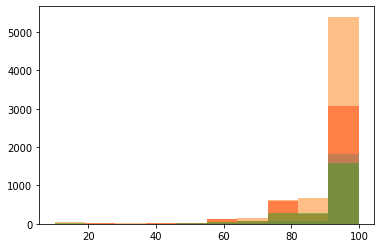

In [285]:
# 따로 그리고 싶다.. 그러나 한 셀 안에..
plt.hist(all_review.query('read_by == "celeb"')['rating'], alpha = 0.5, color = "r")
plt.hist(all_review.query('read_by == "author"')['rating'], alpha = 0.5)
plt.hist(all_review.query('read_by == "someone"')['rating'], alpha = 0.5)
plt.hist(all_review.query('read_by == "robot"')['rating'], alpha = 0.5)

In [237]:
with_review = all_review.dropna(how = 'any', axis = 0)
with_review[with_review['review'].str.contains('들었습')].review.unique()

array(['잘들었습니다.', '잘들었습니다', '잘 들었습니다', '잘 들었습니다  응원합니다♥♥♥', '잘 들었습니다.',
       '가슴에 울리는 내용 잘들었습니다', '잘 들었습니다.\r\n좋습니다.',
       '목소리가 너무너무 좋으셔서 즐겁게 들었습니더', '잠들어질 정도로 잘들었습니다',
       '잘 들었습니다  좋아요   응원합니다♥♥♥', '재미있게 잘 들었습니다',
       '너무 좋고 잘들었습니다 또  내었으면 좋겠네요 다음에 기대 하겠습니다 화이팅!!!!!!',
       '위저드베이커리 읽었었는데ᆢ잘들었습니다', '너무 잘들었습니다 감사합니다', '잘 들었습니다!!',
       '감사합니다 잘들었습니다', '잘들었습니다~', '잠이 깨 새벽에 조용히 들으니 좋으네요\r\n잘들었습니다',
       '잘들었습니다 목소리좋아서 듣기편하네요  미풍을타는 나비가', '장 들었습니다', '정들었습니다!',
       '소여, 좋네요 잘들었습니다', '재밌게 들었습니다', '잘 들었습니다.\r\n감사합니다.', '잘들었습니다~~',
       '좋네요 잘들었습니다', '잘들었습니다!!', '절 들었습니다\r\n감사합니다 ~',
       '건강하게 돌아오셔서 다행이네요 \r\n재미있게 잘들었습니다', '좋은글 잘들었습니다', '자류들었습니다',
       '잘들었습니다 공감가네요', '잘 들었습니다 고맙습니다♥', '재밌게 잘 들었습니다.',
       '눈물나네요.ㅠ 정말 절절하게 공감하며 잘 들었습니다,', '잘 들었습니다~^^', '잘들었습니다! 화이팅입니다',
       '이 책이 베스트셀러이던 시절에도 안 읽고 지나갔는데 오디오북으로 들으니 편하군요. 잘 들었습니다. 감사해요. 유석 성우님 목소리  차분하니 좋아요. 건강하세요~.',
       '잘들었습니다!', '흥미진진하고 재미있게 들었습니다', '좋은 내용 잘들었습니다',
       '차분한 목소리라 집중도 잘되고 듣기좋네요.\r\n잘 들었습

In [222]:
print(f"데이터의 크기는             : {df.shape}")
print(f"데이터에 포함된 유저의 수는 : {len(user_df)}")
print(f"데이터에 포함된 책의 수는   : {len(title_df)}")

데이터의 크기는             : (15965, 3)
데이터에 포함된 유저의 수는 : 4951
데이터에 포함된 책의 수는   : 200


C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


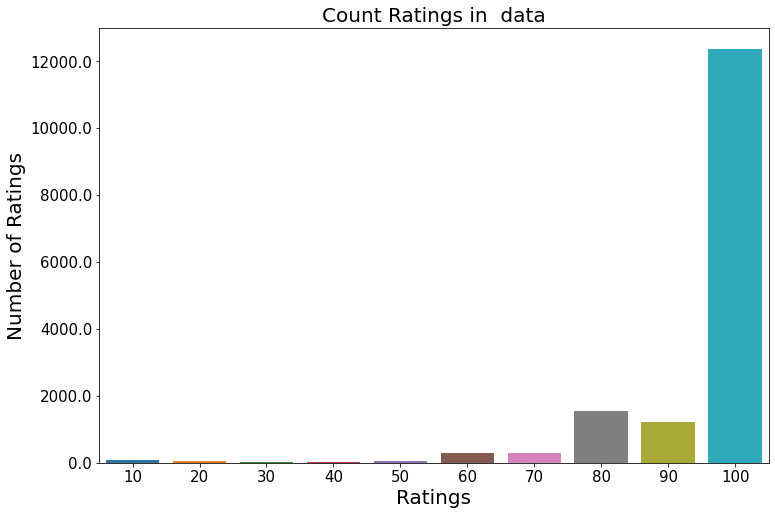

In [7]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in  data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

일단 가장 높은 n개의 값만 보여주는 함수를 만듭니다.

In [8]:
def return_best_n(statistics, n):
    # statistics: array of size review.shape[1] containing one statistic calculated from the dataset
    # n: number of indices to be returned
    # returns: array of size *n* containing the indices of the best scored statistics
    statistics = pd.DataFrame({'statistic':statistics})
    return statistics.sort_values('statistic', ascending = False).iloc[:n]

## 2.1 Mean Rating <a class="anchor" id="bullet2.1"></a>


In [9]:
means = pivot_df.iloc[:,2:].apply(np.mean)
return_best_n(means,10)

,statistic
title,
김의성이 읽는 최인호의 타인의 방,100.0
경제 읽어주는 남자 김광석의 [디지털 경제의 미래],100.0
너의 거기는 작고 나의 여기는 커서 우리들은 헤어지는 중입니다,100.0
정진영이 읽는 김기진의 젊은 이상주의자의 사,100.0
중국식 룰렛,100.0
나만 몰랐던 이야기,100.0
어린이 성경 : 알기 쉬운 성경이야기,100.0
김용 대하역사무협 신조협려 하이라이트,100.0
김영민이 읽는 현경준의 탁류,100.0


## 2.2 Rating Count<a class="anchor" id="bullet2.2"></a>


In [10]:
count = pivot_df.iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count,10)

,statistic
title,
최민식이 읽는 이범선의 오발탄,1445
운명이다,598
어른이 되면 괜찮을 줄 알았다,530
딜리트,521
[강연형] 제국대학의 조센징,498
담배만이 우리 세상,480
[한예리 낭독] 안락 _ 작은책,407
살고 싶다는 농담,392
나는 왠지 대박날 것만 같아!,391


평균 평점 top10의 책은 몇개의 리뷰가 있을까?

In [11]:
top10_avg_ratings = return_best_n(means,10).index
count.loc[top10_avg_ratings]

title
김의성이 읽는 최인호의 타인의 방                    5
경제 읽어주는 남자 김광석의 [디지털 경제의 미래]          1
너의 거기는 작고 나의 여기는 커서 우리들은 헤어지는 중입니다    2
정진영이 읽는 김기진의 젊은 이상주의자의 사              2
중국식 룰렛                                1
나만 몰랐던 이야기                            1
어린이 성경 : 알기 쉬운 성경이야기                  4
김용 대하역사무협 신조협려 하이라이트                  2
김영민이 읽는 현경준의 탁류                       1
길해연이 읽는 양귀자의 원미동 시인                   1
dtype: int64

## 2.3 Percentage of Good Ratings<a class="anchor" id="bullet2.3"></a>


In [12]:
good_count = pivot_df.iloc[:,2:].apply(lambda col : np.sum(col >=  80)/np.sum(~np.isnan(col)))
return_best_n(good_count,3)

,statistic
title,
<테이크아웃 오디오북> 목견,1.0
김의성이 읽는 최인호의 타인의 방,1.0
두 도시 이야기(요약본),1.0


In [13]:
#위 코드 이해하기
col = pivot_df.iloc[:,2:]['나는 왠지 대박날 것만 같아!']
print(np.sum(col >= 80))
print(np.sum(~np.isnan(col)))

387
391


애초에 리뷰가 한개인 경우는 리뷰 수 대비 좋은 리뷰 값이 1로 나옴<br>
이걸 해결하기 위해서 리뷰 숫자가 충분한 경우만 확인

In [14]:
means = pd.DataFrame(means, columns = ['rating_avg'])
count = pd.DataFrame(count, columns = ['no_of_ratings'])
rating_pct = pd.DataFrame(good_count, columns = ['over_80_ratio'])

ratings = pd.merge(left=means, right=count, how='left',left_index=True,right_index=True)

ratings = ratings.merge(rating_pct, how='left',left_index=True,right_index=True)

ratings.sample(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
편의점으로 먹고살기,100.0,3,1.0
[김병관 낭독] 못 먹어도 go! (단편),100.0,1,1.0
신안진이 읽는 이문열의 필론과 돼지,100.0,1,1.0


In [15]:
ratings.query('no_of_ratings > 100').sort_values(by='over_80_ratio', ascending=False).head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
오만과 편견(요약본),99.339623,106,1.000000
열하일기 첫걸음,99.545455,352,0.997159
세계는 왜 싸우는가,99.171975,314,0.996815


<AxesSubplot:>

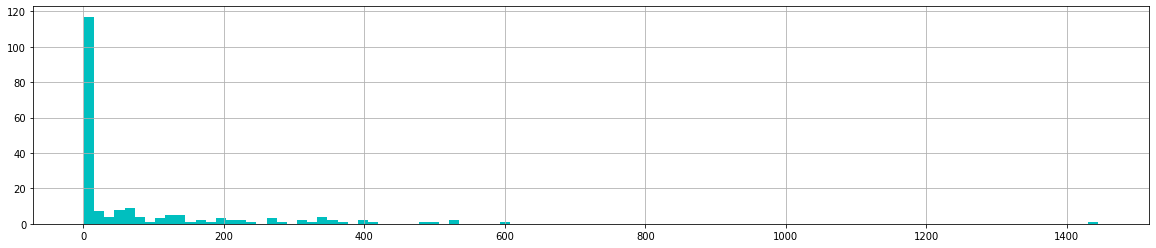

In [16]:
plt.figure(figsize = (20,4))
ratings['no_of_ratings'].hist(bins=100,color='c')

<AxesSubplot:>

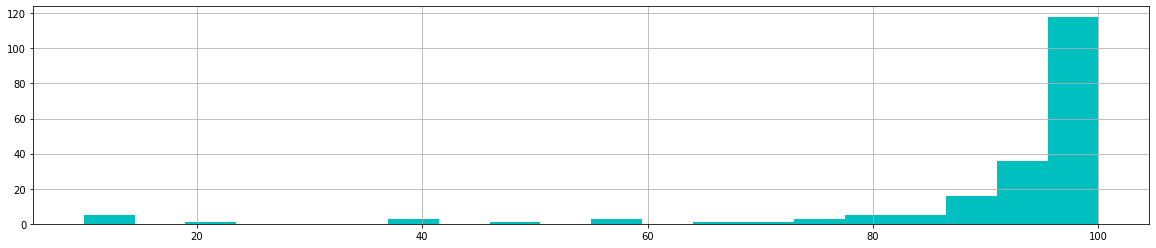

In [17]:
plt.figure(figsize = (20,4))
ratings['rating_avg'].hist(bins=20,color='c')

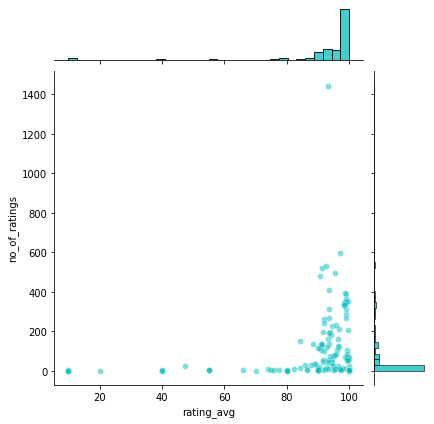

In [18]:
sns.jointplot(x='rating_avg', y='no_of_ratings', data= ratings, alpha = 0.5, color='c')

<div class="alert alert-warning">
분석에서 아래와 같이 rating이 몇개 이상인 책만 뽑아서 봐도 되는것...?
</div>

In [30]:
df.nickname

0            유노창민
1         나이스가이72
2              하브
3              양수
4        티씨지는부산더락
           ...   
17503        후후후크
17504         하루유
17505    pink9964
17506         소민맘
17507        유노창민
Name: nickname, Length: 17508, dtype: object

In [19]:
ratings['no_of_ratings'].describe()

count     198.000000
mean       79.727273
std       157.853708
min         1.000000
25%         1.000000
50%         6.000000
75%        86.750000
max      1445.000000
Name: no_of_ratings, dtype: float64

하위 50%의 분포를 살펴보면: 1~4정도임

In [20]:
ratings['no_of_ratings'].quantile(np.arange(0, 0.5, 0.05))

0.00    1.0
0.05    1.0
0.10    1.0
0.15    1.0
0.20    1.0
0.25    1.0
0.30    2.0
0.35    2.0
0.40    2.0
0.45    4.0
Name: no_of_ratings, dtype: float64

In [21]:
ratings_min_6 = ratings.query('no_of_ratings >= 6')
ratings_min_6.head(3)

,rating_avg,no_of_ratings,over_80_ratio
title,,,
[강연형] 제국대학의 조센징,95.441767,498,0.945783
[공포괴담집] 무조건 모르는 척하세요,93.908629,197,0.949239
[공포괴담집] 저승에서 돌아온 남자,94.405286,227,0.964758


<div class="alert alert-warning">
근본적으로 우리가 책이 200권 정도밖에 없는데, <br>
리뷰 5개 이상인 책으로 바꾸면 그게 반토막 나게됨<br>
그렇게 데이터 수를 희생하면서 봐도 되는 것인지..?<br>
</div>

# 3. Prediction With Surprise<a class="anchor" id="bullet3"></a>

In [321]:
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic

In [291]:
reader = Reader(rating_scale=(10, 100))
data = Dataset.load_from_df(all_review[['nickname', 'title', 'rating']], reader)

In [312]:
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 10.8928
RMSE: 9.7162
RMSE: 10.1348


In [316]:
kf = KFold(n_splits=3)

algo = NMF()

for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 76.8622
RMSE: 76.8241
RMSE: 76.8932


In [320]:
kf = KFold(n_splits=3)

algo = KNNBasic()

for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 10.8977
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 11.1375
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 11.0858
